In [31]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
gdf = gpd.read_file(r'D:\DeepLearning\Projects\temperature_at10m\Data\temperature_downcaling_data.geojson')

In [40]:
gdf

,temperature,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,geometry
0,317.921966,1380.0,1407.0,1817.0,1646.0,2278.0,3673.0,4144.0,4516.0,4465.0,3641.0,2732.0,4350.0,POINT (76.841 12.639)
1,318.749127,1501.0,1844.0,2268.0,2560.0,2777.0,3600.0,3865.0,4256.0,3381.0,4672.0,3703.0,4291.0,POINT (76.845 12.862)
2,321.678370,1617.0,1689.0,2182.0,3322.0,3839.0,4111.0,4298.0,4212.0,4374.0,6170.0,4916.0,4414.0,POINT (76.85 13.081)
3,314.767134,1251.0,1310.0,1670.0,1719.0,2233.0,3578.0,3954.0,4128.0,4400.0,3288.0,2279.0,4324.0,POINT (76.857 13.165)
4,319.087511,1298.0,1298.0,1786.0,1720.0,2225.0,3858.0,4478.0,4504.0,4497.0,3740.0,2571.0,4700.0,POINT (76.859 12.662)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,323.260914,1485.0,1642.0,2216.0,2670.0,2871.0,3424.0,3684.0,3566.0,4565.0,4240.0,3197.0,3775.0,POINT (77.846 13.355)
496,325.004104,1630.0,1764.0,2232.0,2954.0,3627.0,3893.0,4088.0,4020.0,3730.0,5484.0,4297.0,4283.0,POINT (77.848 13.066)
497,322.160311,1417.0,1626.0,2104.0,3156.0,3416.0,3551.0,3691.0,3662.0,3554.0,4957.0,3825.0,3720.0,POINT (77.849 13.169)
498,323.469413,1330.0,1358.0,1794.0,2392.0,2786.0,3821.0,4127.0,4094.0,4046.0,4215.0,3161.0,4116.0,POINT (77.852 13.306)


In [4]:
corr_matrix = gdf.iloc[:,1:-2].corr()

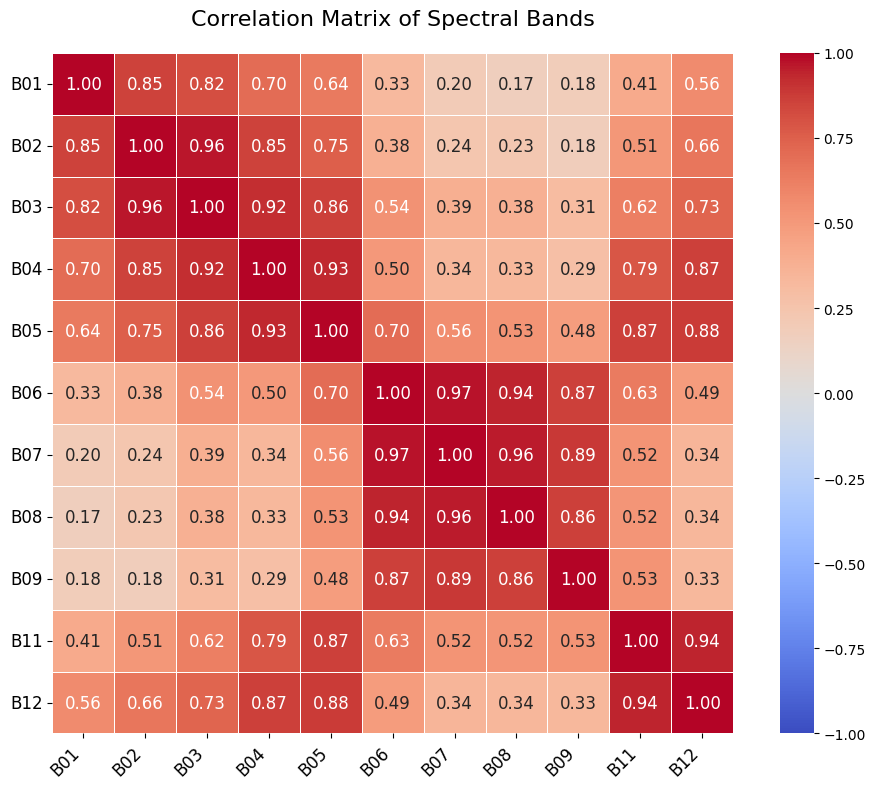

In [5]:
width = 10  # Inches (horizontal size)
height = 8  # Inches (vertical size)

# Create figure with custom size
plt.figure(figsize=(width, height))

# Generate heatmap with key enhancements
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,            # Show correlation values
    fmt=".2f",             # Round decimals
    cmap='coolwarm',       # Color scheme
    vmin=-1, vmax=1,       # Fix color scale
    linewidths=0.5,        # Add grid lines
    square=True,           # Maintain square cells
    annot_kws={"size": 12} # Adjust annotation font size
)

# Improve readability
plt.title(f"Correlation Matrix of Spectral Bands", 
           fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Diagonal X-labels
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

plt.show()

In [6]:
# Final Feature Selection: Bands to Remove and Why
# Remove These 4 Bands:
# B02 (Blue)

# Reason: Near-identical to B03 (Green) with correlation 0.95

# B05 (Red Edge 1)

# Reason: Redundant with B04 (Red) at correlation 0.92

# Impact: B04 captures similar spectral information more efficiently

# B07 (SWIR 2)

# Reason: Extremely high correlation with B06 (SWIR 1) at 0.97

# Impact: Functionally identical to B06 in this dataset

# B12 (SWIR 3)

# Reason: Overlaps significantly with B11 (SWIR 4) at correlation 0.94

# Impact: B11 sufficiently represents thermal characteristics

In [33]:
sentinel_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12', 'B8A']
finals_bands = ['B03', 'B04', 'B05', 'B06', 'B08', 'B09',
       'B11', 'B8A']

In [ ]:
X = gdf.iloc[:,1:-2]
y = gdf['temperature']

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [55]:
# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=80
)

In [56]:
# 3. Initialize and train the regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    # random_state=42,
    early_stopping_rounds=10,
)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric=mean_squared_error,
    verbose=True
)
# 4. Evaluate
preds = model.predict(X_test)
r2  = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"Test R²:  {r2:.4f}")
print(f"Test MAE: {mae:.4f}")

[0]	validation_0-rmse:3.17189	validation_1-rmse:2.99475
[1]	validation_0-rmse:2.61255	validation_1-rmse:2.86100
[2]	validation_0-rmse:2.21601	validation_1-rmse:2.81542
[3]	validation_0-rmse:1.93825	validation_1-rmse:2.82185
[4]	validation_0-rmse:1.76649	validation_1-rmse:2.84472
[5]	validation_0-rmse:1.57200	validation_1-rmse:2.86757
[6]	validation_0-rmse:1.45023	validation_1-rmse:2.87866
[7]	validation_0-rmse:1.33207	validation_1-rmse:2.85883
[8]	validation_0-rmse:1.23448	validation_1-rmse:2.84545
[9]	validation_0-rmse:1.13172	validation_1-rmse:2.86382
[10]	validation_0-rmse:1.08249	validation_1-rmse:2.85717
[11]	validation_0-rmse:1.02507	validation_1-rmse:2.88173
[12]	validation_0-rmse:1.00530	validation_1-rmse:2.89325
Test R²:  0.2594
Test MAE: 2.2680


In [34]:
oneband = list(combinations(sentinel_bands, 1))
twoband = list(combinations(sentinel_bands, 2))
threeband = list(combinations(sentinel_bands, 3))
fourband = list(combinations(sentinel_bands, 4))
fiveband = list(combinations(sentinel_bands, 5))
sixband = list(combinations(sentinel_bands, 6))
sevenband = list(combinations(sentinel_bands, 7))
eightband = list(combinations(sentinel_bands, 8))
nineband = list(combinations(sentinel_bands, 9))
tenband = list(combinations(sentinel_bands, 10))
elevenlband = list(combinations(sentinel_bands, 11))
tweleveband = list(combinations(sentinel_bands, 12))
# On All bands and their combinations

In [63]:
def XGB_regression(bands, X_train, X_test, y_train, y_test):
    results = []
    for i, comb in enumerate(bands):
        X_train_subset = X_train[list(comb)]
        X_test_subset = X_test[list(comb)]
        
        # Initialize XGBRegressor
        model = xgb.XGBRegressor(n_estimators = 300,eval_metric=mean_absolute_error,early_stopping_rounds=15,verbosity=1)
        model.fit(X_train_subset, y_train,eval_set=[(X_test_subset, y_test)])  # Fit the model
    
        # Predictions
        y_pred = model.predict(X_test_subset)
    
        # Metrics
        train_r2 = model.score(X_train_subset, y_train)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)
        
        # Store results
        results.append({
            'Combination': comb,
            'Train R²': train_r2,
            'MSE': mse,
            'MAE': mae,
            'Test R²': test_r2
        })
    return results

In [64]:
X = gdf[sentinel_bands]
y = gdf['temperature']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=75
)

In [65]:
%%capture
results_df_oneband_xgb = pd.DataFrame(XGB_regression(oneband,X_train,X_test,y_train,y_test))
results_df_twoband_xgb = pd.DataFrame(XGB_regression(twoband,X_train,X_test,y_train,y_test))
results_df_threeband_xgb = pd.DataFrame(XGB_regression(threeband,X_train,X_test,y_train,y_test))
results_df_fourband_xgb = pd.DataFrame(XGB_regression(fourband,X_train,X_test,y_train,y_test))
results_df_fiveband_xgb = pd.DataFrame(XGB_regression(fiveband,X_train,X_test,y_train,y_test))
results_df_sixnd_xgb = pd.DataFrame(XGB_regression(sixband,X_train,X_test,y_train,y_test))
results_df_svenband_xgb = pd.DataFrame(XGB_regression(sevenband,X_train,X_test,y_train,y_test))
results_df_eightband_xgb = pd.DataFrame(XGB_regression(eightband,X_train,X_test,y_train,y_test))
results_df_nineband_xgb = pd.DataFrame(XGB_regression(nineband,X_train,X_test,y_train,y_test))
results_df_tenband_xgb = pd.DataFrame(XGB_regression(tenband,X_train,X_test,y_train,y_test))
results_df_elevenlband_xgb = pd.DataFrame(XGB_regression(elevenlband,X_train,X_test,y_train,y_test))
results_df_tweleveband_xgb = pd.DataFrame(XGB_regression(tweleveband,X_train,X_test,y_train,y_test))

In [67]:
dfs = {
    '1-band':   results_df_oneband_xgb,
    '2-band':   results_df_twoband_xgb,
    '3-band':   results_df_threeband_xgb,
    '4-band':   results_df_fourband_xgb,
    '5-band':   results_df_fiveband_xgb,
    '6-band':   results_df_sixnd_xgb,
    '7-band':   results_df_svenband_xgb,
    '8-band':   results_df_eightband_xgb,
    '9-band':   results_df_nineband_xgb,
    '10-band':  results_df_tenband_xgb,
    '11-band':  results_df_elevenlband_xgb,
    '12-band':  results_df_tweleveband_xgb,
}

for label, df in dfs.items():
    idx = df['Test R²'].idxmax()
    max_test = df.at[idx, 'Test R²']
    train_at_max = df.at[idx, 'Train R²']
    band_combination = df.at[idx, 'Combination']
    print(f"{label} → max Test R² = {max_test:.4f}, corresponding Train R² = {train_at_max:.4f} for combination{band_combination}")

1-band → max Test R² = 0.4154, corresponding Train R² = 0.4555 for combination('B01',)
2-band → max Test R² = 0.5202, corresponding Train R² = 0.7526 for combination('B02', 'B12')
3-band → max Test R² = 0.5900, corresponding Train R² = 0.8032 for combination('B02', 'B09', 'B11')
4-band → max Test R² = 0.6064, corresponding Train R² = 0.9081 for combination('B02', 'B09', 'B11', 'B12')
5-band → max Test R² = 0.6059, corresponding Train R² = 0.9013 for combination('B01', 'B02', 'B04', 'B09', 'B11')
6-band → max Test R² = 0.5951, corresponding Train R² = 0.9882 for combination('B01', 'B02', 'B03', 'B09', 'B11', 'B12')
7-band → max Test R² = 0.5970, corresponding Train R² = 0.9213 for combination('B01', 'B02', 'B03', 'B04', 'B05', 'B09', 'B11')
8-band → max Test R² = 0.6181, corresponding Train R² = 0.9984 for combination('B01', 'B02', 'B03', 'B08', 'B09', 'B11', 'B12', 'B8A')
9-band → max Test R² = 0.5884, corresponding Train R² = 0.9163 for combination('B01', 'B02', 'B03', 'B05', 'B08', '

In [ ]:
best_band_combo = ['B01', 'B02', 'B03', 'B08', 'B09', 'B11', 'B12', 'B8A']

In [61]:
X = gdf[best_band_combo]
y = gdf['temperature']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=75
)

In [62]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    # random_state=42,
    early_stopping_rounds=10,
)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric=mean_squared_error,
    verbose=True
)
# 4. Evaluate
preds = model.predict(X_test)
r2  = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"Test R²:  {r2:.4f}")
print(f"Test MAE: {mae:.4f}")

[0]	validation_0-rmse:3.02255	validation_1-rmse:3.61524
[1]	validation_0-rmse:2.53033	validation_1-rmse:3.22010
[2]	validation_0-rmse:2.17630	validation_1-rmse:2.93930
[3]	validation_0-rmse:1.91680	validation_1-rmse:2.83098
[4]	validation_0-rmse:1.75167	validation_1-rmse:2.77765
[5]	validation_0-rmse:1.59717	validation_1-rmse:2.73725
[6]	validation_0-rmse:1.45488	validation_1-rmse:2.69865
[7]	validation_0-rmse:1.32198	validation_1-rmse:2.67751
[8]	validation_0-rmse:1.21324	validation_1-rmse:2.66028
[9]	validation_0-rmse:1.13723	validation_1-rmse:2.63825
[10]	validation_0-rmse:1.05962	validation_1-rmse:2.63867
[11]	validation_0-rmse:1.01325	validation_1-rmse:2.64674
[12]	validation_0-rmse:0.96854	validation_1-rmse:2.65889
[13]	validation_0-rmse:0.89194	validation_1-rmse:2.62904
[14]	validation_0-rmse:0.85303	validation_1-rmse:2.61750
[15]	validation_0-rmse:0.81661	validation_1-rmse:2.62826
[16]	validation_0-rmse:0.75800	validation_1-rmse:2.63219
[17]	validation_0-rmse:0.70980	validation

In [68]:
# 6. Save the model
model.save_model(r"D:\DeepLearning\Projects\temperature_at10m\model\temp_99_61.json")